## Methodology

The code provided implements a deep learning pipeline for image classification using pre-trained models. The pipeline consists of the following steps:

1. Setting seeds: The `set_seeds` function sets the random seeds to ensure reproducibility of the results.

2. CustomDataset class: This class is used to create a custom dataset for loading and preprocessing the image data. It takes the image directory, labels file, and optional transformations as inputs. The class provides methods to retrieve the length of the dataset and individual data items.

3. Device setup: The code checks if a GPU is available and sets the device accordingly.

4. Data preparation:
    - Loading labeled dataset: The labeled dataset is loaded from a CSV file containing image labels.
    - Finding maximum size: The maximum width and height of the images in the dataset are determined.
    - Data transformation: Two main data transformation pipelines are defined:
        - `main_transform`: Resizes the images to the maximum width and height, converts them to tensors, and applies normalization.
        - `augmentation_transform`: Includes resizing, random flips, rotation, color jitter, and normalization for data augmentation.
    - Dataset creation: The main dataset and augmented dataset are created using the `CustomDataset` class and the respective transformation pipelines.
    - Combining datasets: The main dataset and augmented dataset are combined using the `ConcatDataset` class.
    - Stratified k-fold cross-validation: The combined dataset is split into train and validation sets using stratified k-fold cross-validation.

5. Model setup:
    - Pre-trained model loading: Several pre-trained models from the torchvision library are loaded, including ResNet50, EfficientNetV2, Inception V3, and GoogLeNet.
    - Model adaptation: The last fully connected layers (classifiers) of each model are replaced with new linear layers to match the number of classes in the current task.
    - Model device placement: The models are moved to the specified device (GPU if available).

6. Training loop:
    - Loss function and optimizer: The cross-entropy loss and Adam optimizer are defined for each model.
    - Training phase: The training loop iterates over the specified number of epochs and performs the following steps for each model:
        - Sets the model to train mode and initializes the running loss.
        - Iterates over the training dataloader and performs the following steps for each batch:
            - Moves the images and labels to the specified device.
            - Clears the gradients from the previous iteration.
            - Performs a forward pass through the model to get the outputs.
            - Computes the loss by comparing the outputs with the ground truth labels.
            - Performs backpropagation to compute the gradients.
            - Updates the model parameters based on the gradients using the optimizer.
            - Accumulates the running loss.
        - Calculates the average loss for the epoch and prints it.

7. Evaluation:
    - Validation phase: After each training epoch, the models are evaluated on the validation set.
    - Evaluation metrics: Various evaluation metrics such as accuracy, F1 score, and recall are calculated using the predictions and true labels.
    - Best model selection: The model with the best validation loss, F1 score, and accuracy is selected and saved.

8. Model testing: The selected best model is used to make predictions on the test set.

## Equations and Formulas

1. Class weights calculation:
   - Formula: `class_weights = 1.0 / torch.tensor(np.bincount(stacked_labels[train_index]))`
   - Description: Compute the class weights by taking the reciprocal of the counts of each class in the training set. This gives more weight to underrepresented classes and less weight to overrepresented classes.

2. Cross-Entropy Loss:
   - Formula: ![Cross-Entropy Loss](https://latex.codecogs.com/png.latex?%5Ctext%7BCrossEntropyLoss%7D%28%5Cmathbf%7Bp%7D%2C%20%5Cmathbf%7Bq%7D%29%20%3D%20-%20%5Csum_i%20p_i%20%5Clog%20q_i)
   - Description: The cross-entropy loss measures the dissimilarity between the predicted probability distribution (q) and the true probability distribution (p) of the classes. It is commonly used as a loss function in multi-class classification problems. The formula sums over all classes (i) and calculates the negative log-likelihood of the true class probabilities predicted by the model.

3. Adam Optimizer:
   - Formula for parameter update:
     ![Adam Optimizer Update](https://latex.codecogs.com/png.latex?%5Ctheta_%7Bt&plus;1%7D%20%3D%20%5Ctheta_t%20-%20%5Cfrac%7B%5Ctext%7BLearningRate%7D%7D%7B%5Csqrt%7B%5Chat%7Bv%7D_t%7D%20&plus;%20%5Cepsilon%7D%20%5Codot%20%5Chat%7Bm%7D_t)
   - Description: The Adam optimizer is an adaptive learning rate optimization algorithm commonly used in deep learning. It computes individual learning rates for different parameters by estimating first and second moments of the gradients. The formula calculates the updated parameter values (θ) based on the previous parameter values (θt), the learning rate (LearningRate), the estimated first moment of the gradient (m), the estimated second moment of the gradient (v), and a small epsilon value for numerical stability.

4. Accuracy:
   - Formula: ![Accuracy](https://latex.codecogs.com/png.latex?%5Ctext%7BAccuracy%7D%20%3D%20%5Cfrac%7B%5Ctext%7BNumber%20of%20correct%20predictions%7D%7D%7B%5Ctext%7BTotal%20number%20of%20predictions%7D%7D)
   - Description: Accuracy is a common evaluation metric used in classification tasks. It measures the percentage of correct predictions out of the total number of predictions made by the model.

5. F1 Score:
   - Formula: ![F1 Score](https://latex.codecogs.com/png.latex?%5Ctext%7BF1%20Score%7D%20%3D%20%5Cfrac%7B2%20%5Ctimes%20%5Ctext%7BPrecision%7D%20%5Ctimes%20%5Ctext%7BRecall%7D%7D%7B%5Ctext%7BPrecision%7D%20&plus;%20%5Ctext%7BRecall%7D%7D)
   - Description: The F1 score is the harmonic mean of precision and recall. It is a single metric that combines both precision (the ability of the model to correctly predict positive samples) and recall (the ability of the model to find all positive samples). The F1 score is commonly used when there is an imbalance between the number of positive and negative samples in the dataset.

6. Recall (Sensitivity):
   - Formula: ![Recall](https://latex.codecogs.com/png.latex?%5Ctext%7BRecall%7D%20%3D%20%5Cfrac%7B%5Ctext%7BTrue%20Positives%7D%7D%7B%5Ctext%7BTrue%20Positives%7D%20&plus;%20%5Ctext%7BFalse%20Negatives%7D%7D)
   - Description: Recall, also known as sensitivity or true positive rate, measures the proportion of actual positive samples that are correctly identified by the model. It is a useful metric when the goal is to minimize false negatives.

These are just a few examples of commonly used mathematical notations and formulas in machine learning. There are many other concepts and equations used in various algorithms and models depending on the specific task at hand.

In [1]:
import os
import re
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import *
from torchvision import transforms
from torchvision.models import *
from sklearn.utils import class_weight

from torchvision import models
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

import random

def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call the function to set the seeds
set_seeds()

In [2]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, labels_file, transform=None, filenames=None, labels=None):
        """
        CustomDataset class constructor.

        Parameters:
        - image_dir (str): Directory path where the images are located.
        - labels_file (str): File path of the CSV file containing the labels.
        - transform (callable, optional): Optional transform to be applied to the images.
        - filenames (list, optional): List of filenames corresponding to the images.
        - labels (list, optional): List of labels corresponding to the images.
        """
        self.image_dir = image_dir
        self.labels_df = pd.read_csv(labels_file)
        self.transform = transform

        # Use provided filenames and labels if available
        if filenames is not None and labels is not None:
            self.filenames = filenames
            self.labels = labels
            self.use_additional_data = True
        else:
            self.filenames = self.labels_df['id'].astype(str).values
            self.labels = self.labels_df['malignant'].values + 1
            self.use_additional_data = False

    def __len__(self):
        """
        Returns the number of samples in the dataset.

        Returns:
        - int: Number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieves an item from the dataset.

        Parameters:
        - idx (int): Index of the item to retrieve.

        Returns:
        - tuple: A tuple containing the image and its corresponding label.
        """
        if self.use_additional_data:
            img_path = os.path.join(self.image_dir, 'img_' + str(self.filenames[idx]) + '.png')
        else:
            img_path = os.path.join(self.image_dir, 'img_' + str(self.labels_df.iloc[idx]['id']) + '.png')

        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Check if CUDA is available and set the device to GPU if it is, otherwise use CPU.


# Set the directory paths
image_dir = '/kaggle/input/oxml-carinoma-classification'
labels_file = '/kaggle/input/oxml-carinoma-classification/labels.csv'
# Set the paths to the directory containing the images and the labels CSV file.


# Load the labeled dataset
labeled_data = pd.read_csv(labels_file)
# Read the CSV file containing the labels into a Pandas DataFrame and store it in labeled_data.


# Get the labeled image filenames and their corresponding labels
labeled_filenames = labeled_data['id'].astype(str).values
labels = labeled_data['malignant'].values + 1
# Extract the filenames and labels from the labeled_data DataFrame and store them in labeled_filenames and labels respectively.


# Find the maximum size
max_width = 0
max_height = 0
# Initialize variables to store the maximum width and height of the images.

for file_name in labeled_filenames:
    file_path = os.path.join(image_dir, "img_" + file_name + '.png')
    image = Image.open(file_path)
    width, height = image.size
    max_width = max(max_width, width)
    max_height = max(max_height, height)
    # Iterate over the labeled_filenames and open each image using PIL.
    # Get the width and height of each image and update the maximum width and height if necessary.


# Define the main data transform
main_transform = transforms.Compose([
    transforms.Resize((max_height, max_width)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Create a transformation pipeline using transforms.Compose.
# The pipeline resizes the images to the maximum width and height found earlier,
# converts them to tensors, and applies normalization.


# Create the main dataset
dataset = CustomDataset(image_dir, labels_file, transform=main_transform)
# Create an instance of the CustomDataset class using the image_dir, labels_file,
# and the main_transform defined above.


# Define data augmentation transforms
augmentation_transform = transforms.Compose([
    transforms.Resize((max_height, max_width)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Create another transformation pipeline for data augmentation.
# The pipeline includes resizing, random horizontal and vertical flips,
# random rotation, color jitter, tensor conversion, and normalization.


dataset_augmented = CustomDataset(image_dir, labels_file, transform=augmentation_transform)
# Create another instance of the CustomDataset class using the image_dir, labels_file,
# and the augmentation_transform defined above.


# Define data augmentation transforms 2
augmentation_transform_2 = transforms.Compose([
    transforms.Resize((max_height, max_width)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((max_height, max_width), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Create a third transformation pipeline for more data augmentation.
# The pipeline includes resizing, random horizontal and vertical flips,
# random rotation, color jitter, random affine transformation, random resized crop,
# random perspective, tensor conversion, and normalization.


dataset_augmented_2 = CustomDataset(image_dir, labels_file, transform=augmentation_transform_2)
# Create another instance of the CustomDataset class using the image_dir, labels_file,
# and the augmentation_transform_2 defined above.


stacked_dataset = ConcatDataset([dataset, dataset_augmented])
# Combine the main dataset and the augmented dataset using ConcatDataset.
# This creates a single dataset that contains both original and augmented data.

stacked_labels = np.concatenate([labels, labels])
# Concatenate the labels array with itself to match the combined dataset size.
# This ensures that the labels are aligned with the corresponding images in stacked_dataset.


# Define the number of folds for k-fold cross-validation
k_folds = 8
# Specify the number of folds to use for k-fold cross-validation.


# Perform k-fold cross-validation
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
# Create an instance of StratifiedKFold, which performs stratified k-fold cross-validation.
# It splits the data into k folds while preserving the class distribution.
# The shuffle parameter is set to True to shuffle the data before splitting,
# and the random_state is set to 42 for reproducibility.


fold_scores = []
# Create an empty list to store the scores for each fold.


for fold, (train_index, val_index) in enumerate(skf.split(stacked_dataset, stacked_labels)):
    # Iterate over each fold generated by the StratifiedKFold object.

    print(f"Training on fold {fold + 1}/{k_folds}")

    # Split the dataset into train and validation sets for the current fold
    train_data = [stacked_dataset[idx] for idx in train_index]
    val_data = [stacked_dataset[idx] for idx in val_index]
    # Obtain the indices for the training and validation data for the current fold
    # and extract the corresponding data from the stacked_dataset.


    # Convert labels to numpy array for indexing
    stacked_labels = np.array(stacked_labels)
    # Convert the stacked_labels to a numpy array for easier indexing.


    # Calculate class weights
    class_weights = 1.0 / torch.tensor(np.bincount(stacked_labels[train_index]))
    # Compute the class weights by taking the reciprocal of the counts of each class in the training set.
    # This gives more weight to underrepresented classes and less weight to overrepresented classes.
    train_class_weights = class_weights[stacked_labels[train_index]]
    # Extract the class weights corresponding to the training labels.


    # Create the weighted sampler
    sampler = WeightedRandomSampler(train_class_weights, len(train_data), replacement=True)
    # Create a WeightedRandomSampler, which samples elements from the training data with replacement
    # according to the specified class weights. This oversamples the underrepresented classes
    # during training to balance the class distribution.


    # Create the data loaders with weighted sampling
    batch_size = 8
    train_dataloader = DataLoader(train_data, batch_size=batch_size, sampler=sampler)
    # Create a DataLoader for the training data, using the WeightedRandomSampler to sample batches.
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    # Create a DataLoader for the validation data without sampling, shuffling the data within each epoch is not needed in validation.


Training on fold 1/8
Training on fold 2/8
Training on fold 3/8
Training on fold 4/8
Training on fold 5/8
Training on fold 6/8
Training on fold 7/8
Training on fold 8/8


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 83.1MB/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed 

Epoch 1/3 - ResNet50 Training Loss: 1.1410
Epoch 1/3 - EfficientNetV2 Training Loss: 1.0820
Epoch 1/3 - Inception V3 Training Loss: 1.1715
Epoch 1/3 - GoogLeNet Training Loss: 1.1122
Epoch 1/3 - Validation Loss: 1.1064, F1 Score: 0.1906, Accuracy: 0.2667
Confusion Matrix:
tensor([[1, 8, 0],
        [0, 3, 0],
        [0, 3, 0]])


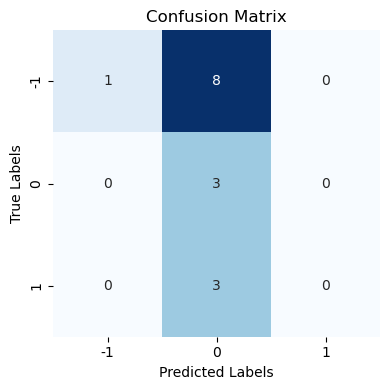

Performance Metrics:
--------------------
Accuracy: 0.2667
Macro-Precision: nan
Macro-Recall: 0.3704
Macro-F1 Score: nan
Micro-Precision: 0.2667
Micro-Recall: 0.2667
Micro-F1 Score: 0.2667
Saved the best models based on validation accuracy: 0.26666666666666666
Epoch 2/3 - ResNet50 Training Loss: 1.0625
Epoch 2/3 - EfficientNetV2 Training Loss: 1.0837
Epoch 2/3 - Inception V3 Training Loss: 1.1341
Epoch 2/3 - GoogLeNet Training Loss: 1.0987
Epoch 2/3 - Validation Loss: 1.0511, F1 Score: 0.7133, Accuracy: 0.7333
Confusion Matrix:
tensor([[8, 1, 0],
        [1, 2, 0],
        [2, 0, 1]])


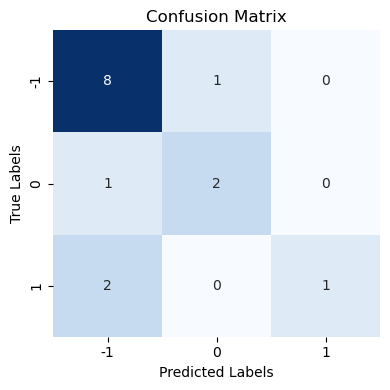

Performance Metrics:
--------------------
Accuracy: 0.7333
Macro-Precision: 0.7980
Macro-Recall: 0.6296
Macro-F1 Score: 0.6556
Micro-Precision: 0.7333
Micro-Recall: 0.7333
Micro-F1 Score: 0.7333
Saved the best models based on validation accuracy: 0.7333333333333333
Epoch 3/3 - ResNet50 Training Loss: 0.9298
Epoch 3/3 - EfficientNetV2 Training Loss: 1.0511
Epoch 3/3 - Inception V3 Training Loss: 1.1163
Epoch 3/3 - GoogLeNet Training Loss: 1.0534
Epoch 3/3 - Validation Loss: 1.0391, F1 Score: 0.5371, Accuracy: 0.6000
Confusion Matrix:
tensor([[8, 1, 0],
        [2, 0, 1],
        [2, 0, 1]])


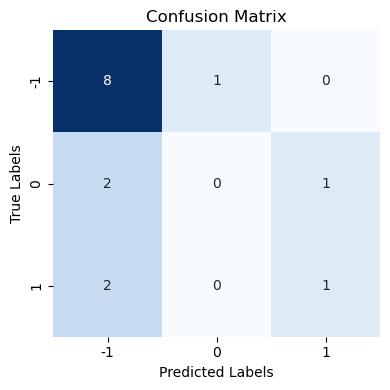

Performance Metrics:
--------------------
Accuracy: 0.6000
Macro-Precision: 0.3889
Macro-Recall: 0.4074
Macro-F1 Score: nan
Micro-Precision: 0.6000
Micro-Recall: 0.6000
Micro-F1 Score: 0.6000
Training complete.


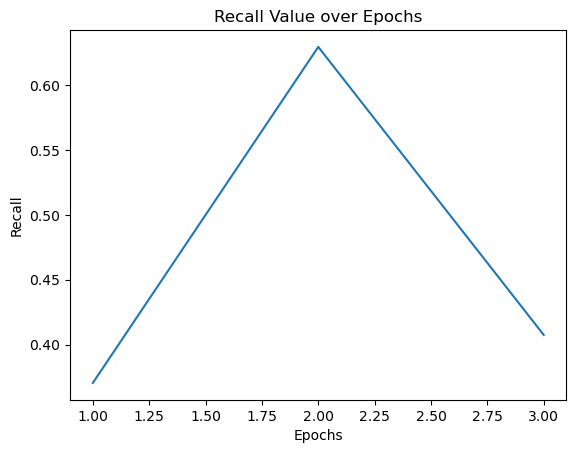

In [3]:


recall_values = []
# Create an empty list to store the recall values.


# Load pre-trained models
resnet_model = models.resnet50(pretrained=True)
efficientnet_model = models.efficientnet_v2_s(pretrained=True)
inception_model = models.inception_v3(pretrained=True, aux_logits=True)
googlenet_model = models.googlenet(pretrained=True)
# Load pre-trained models from torchvision.models.
# The models used here are ResNet50, EfficientNetV2, Inception V3, and GoogLeNet.
# These models have been pre-trained on large-scale image classification datasets such as ImageNet.


# Freeze all the parameters of the pretrained models
for param in resnet_model.parameters():
    param.requires_grad = False
for param in efficientnet_model.parameters():
    param.requires_grad = False
for param in inception_model.parameters():
    param.requires_grad = False
for param in googlenet_model.parameters():
    param.requires_grad = False
# Set the `requires_grad` attribute of all parameters in the pre-trained models to False.
# This freezes the parameters, preventing them from being updated during training.


# Replace the last fully connected layers to match the number of classes
num_classes = 3
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)
efficientnet_model.classifier[-1] = nn.Linear(efficientnet_model.classifier[-1].in_features, num_classes)
inception_model.fc = nn.Linear(inception_model.fc.in_features, num_classes)
googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, num_classes)
# Replace the last fully connected layers (classifiers) of each pre-trained model with a new linear layer.
# This adaptation is necessary to match the number of classes in the current task.


# Move the models to the device (GPU if available)
resnet_model = resnet_model.to(device)
efficientnet_model = efficientnet_model.to(device)
inception_model = inception_model.to(device)
googlenet_model = googlenet_model.to(device)
# Move the models to the specified device (GPU if available) for faster computation.


# Define the loss function
criterion = nn.CrossEntropyLoss()
# Create an instance of the CrossEntropyLoss class, which combines a softmax layer and a negative log-likelihood loss.
# This loss function is commonly used for multi-class classification problems.


# Define the optimizers for each model
optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=0.001)
optimizer_efficientnet = optim.Adam(efficientnet_model.parameters(), lr=0.001)
optimizer_inception = optim.Adam(inception_model.parameters(), lr=0.001)
optimizer_googlenet = optim.Adam(googlenet_model.parameters(), lr=0.001)
# Create instances of the Adam optimizer for each model, specifying the learning rate (lr).
# Adam is an optimization algorithm commonly used for training neural networks.


# Set the initial best validation loss and accuracy
best_val_loss = float('inf')
best_val_f1 = 0.0
best_val_acc = 0.0
# Initialize variables to store the best validation loss, F1 score, and accuracy.


# Training loop
num_epochs = 3
# Set the number of training epochs.
for epoch in range(num_epochs):
    # Training phase for ResNet50
    resnet_model.train()
    # Set the model to train mode.
    running_loss = 0.0
    # Initialize the running loss for the current epoch.
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        # Move the images and labels to the specified device (GPU if available).

        optimizer_resnet.zero_grad()
        # Clear the gradients from the previous iteration.

        outputs = resnet_model(images)
        # Perform a forward pass of the images through the ResNet50 model to get the outputs.

        loss = criterion(outputs, labels)
        # Compute the loss by comparing the model outputs with the ground truth labels.

        loss.backward()
        # Perform backpropagation to compute the gradients of the loss with respect to the model parameters.

        optimizer_resnet.step()
        # Update the model parameters based on the computed gradients using the optimizer.

        running_loss += loss.item()
        # Accumulate the running loss for the current epoch.

    epoch_loss = running_loss / len(train_dataloader)
    # Calculate the average loss for the current epoch.

    print(f"Epoch {epoch+1}/{num_epochs} - ResNet50 Training Loss: {epoch_loss:.4f}")
    # Print the training loss for the current epoch.


    # Training phase for EfficientNetV2
    efficientnet_model.train()
    # Set the model to train mode.
    running_loss = 0.0
    # Initialize the running loss for the current epoch.
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        # Move the images and labels to the specified device (GPU if available).

        optimizer_efficientnet.zero_grad()
        # Clear the gradients from the previous iteration.

        outputs = efficientnet_model(images)
        # Perform a forward pass of the images through the EfficientNetV2 model to get the outputs.

        loss = criterion(outputs, labels)
        # Compute the loss by comparing the model outputs with the ground truth labels.

        loss.backward()
        # Perform backpropagation to compute the gradients of the loss with respect to the model parameters.

        optimizer_efficientnet.step()
        # Update the model parameters based on the computed gradients using the optimizer.

        running_loss += loss.item()
        # Accumulate the running loss for the current epoch.

    epoch_loss = running_loss / len(train_dataloader)
    # Calculate the average loss for the current epoch.

    print(f"Epoch {epoch+1}/{num_epochs} - EfficientNetV2 Training Loss: {epoch_loss:.4f}")
    # Print the training loss for the current epoch.


    # Training phase for Inception V3
    inception_model.train()
    # Set the model to train mode.
    running_loss = 0.0
    # Initialize the running loss for the current epoch.
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        # Move the images and labels to the specified device (GPU if available).

        # Forward pass
        outputs = inception_model(images)
        logits = outputs.logits  # Get the output logits

        loss = criterion(logits, labels)
        # Compute the loss by comparing the model outputs (logits) with the ground truth labels.

        optimizer_inception.zero_grad()
        # Clear the gradients from the previous iteration.

        loss.backward()
        # Perform backpropagation to compute the gradients of the loss with respect to the model parameters.

        optimizer_inception.step()
        # Update the model parameters based on the computed gradients using the optimizer.

        running_loss += loss.item()
        # Accumulate the running loss for the current epoch.

    epoch_loss = running_loss / len(train_dataloader)
    # Calculate the average loss for the current epoch.

    print(f"Epoch {epoch+1}/{num_epochs} - Inception V3 Training Loss: {epoch_loss:.4f}")
    # Print the training loss for the current epoch.


    # Training phase for GoogLeNet
    googlenet_model.train()
    # Set the model to train mode.
    running_loss = 0.0
    # Initialize the running loss for the current epoch.
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        # Move the images and labels to the specified device (GPU if available).

        optimizer_googlenet.zero_grad()
        # Clear the gradients from the previous iteration.

        outputs = googlenet_model(images)
        # Perform a forward pass of the images through the GoogLeNet model to get the outputs.

        loss = criterion(outputs, labels)
        # Compute the loss by comparing the model outputs with the ground truth labels.

        loss.backward()
        # Perform backpropagation to compute the gradients of the loss with respect to the model parameters.

        optimizer_googlenet.step()
        # Update the model parameters based on the computed gradients using the optimizer.

        running_loss += loss.item()
        # Accumulate the running loss for the current epoch.

    epoch_loss = running_loss / len(train_dataloader)
    # Calculate the average loss for the current epoch.

    print(f"Epoch {epoch+1}/{num_epochs} - GoogLeNet Training Loss: {epoch_loss:.4f}")
    # Print the training loss for the current epoch.


    # Validation phase
    resnet_model.eval()
    efficientnet_model.eval()
    inception_model.eval()
    googlenet_model.eval()
    # Set all the models to evaluation mode.

    val_loss = 0.0
    # Initialize the validation loss.
    val_f1 = 0.0
    # Initialize the F1 score.
    val_accuracy = 0.0
    # Initialize the accuracy.
    total_predictions = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total predictions.
    total_labels = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total labels.
    confusion = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    confusion = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    # Initialize the confusion matrix.

    with torch.no_grad():
        # Disable gradient computation since no backward pass is needed during validation.
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            # Move the images and labels to the specified device (GPU if available).

            # ResNet50
            resnet_outputs = resnet_model(images)
            resnet_loss = criterion(resnet_outputs, labels)
            # Compute the loss for the ResNet50 model.

            # EfficientNetV2
            efficientnet_outputs = efficientnet_model(images)
            efficientnet_loss = criterion(efficientnet_outputs, labels)
            # Compute the loss for the EfficientNetV2 model.

            # Inception V3
            inception_outputs = inception_model(images)
            inception_loss = criterion(inception_outputs, labels)
            # Compute the loss for the Inception V3 model.

            # GoogLeNet
            googlenet_outputs = googlenet_model(images)
            googlenet_loss = criterion(googlenet_outputs, labels)
            # Compute the loss for the GoogLeNet model.

            # Combine losses
            loss = (resnet_loss + efficientnet_loss + inception_loss + googlenet_loss) / 4.0
            # Combine the losses from all models by taking their average.

            val_loss += loss.item()
            # Accumulate the validation loss.

            # Calculate accuracy
            _, predictions = torch.max((resnet_outputs + efficientnet_outputs + inception_outputs + googlenet_outputs) / 4.0, dim=1)
            # Combine the predictions from all models by taking their average and get the class with the maximum score.

            total_predictions = torch.cat((total_predictions, predictions), dim=0)
            total_labels = torch.cat((total_labels, labels), dim=0)
            # Concatenate the predictions and labels to the total tensors.

            # Calculate the F1 score and update the confusion matrix
            confusion += confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy(), labels=range(num_classes))

    val_loss /= len(val_dataloader)
    # Calculate the average validation loss.

    val_f1 = f1_score(total_labels.cpu(), total_predictions.cpu(), average='weighted')
    # Calculate the F1 score.

    val_accuracy = accuracy_score(total_labels.cpu(), total_predictions.cpu())
    # Calculate the accuracy.

    print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss:.4f}, F1 Score: {val_f1:.4f}, Accuracy: {val_accuracy:.4f}")
    print("Confusion Matrix:")
    print(confusion)
    # Print the validation loss, F1 score, and accuracy for the current epoch.
    
    # Define class labels (replace with your actual class labels)
    class_labels = ['-1', '0', '1',]


    # Plot confusion matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(confusion, annot=True, fmt="d", cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # Customize plot appearance
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # Display the plot
    plt.show()

    # Calculate overall accuracy
    total_samples = confusion.sum()
    correct_predictions = confusion.diagonal().sum()
    accuracy = correct_predictions / total_samples

    # Calculate precision, recall, and F1-score for each class
    precision = confusion.diagonal() / confusion.sum(axis=0)
    recall = confusion.diagonal() / confusion.sum(axis=1)
    f1_score_cpu = 2 * (precision * recall) / (precision + recall)

    # Calculate macro-averaged metrics
    macro_precision = precision.mean()
    macro_recall = recall.mean()
    macro_f1_score = f1_score_cpu.mean()

    # Calculate micro-averaged metrics
    micro_precision = correct_predictions / total_samples
    micro_recall = correct_predictions / total_samples
    micro_f1_score = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)

    # Print performance metrics
    print("Performance Metrics:")
    print("--------------------")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro-Precision: {macro_precision:.4f}")
    print(f"Macro-Recall: {macro_recall:.4f}")
    print(f"Macro-F1 Score: {macro_f1_score:.4f}")
    print(f"Micro-Precision: {micro_precision:.4f}")
    print(f"Micro-Recall: {micro_recall:.4f}")
    print(f"Micro-F1 Score: {micro_f1_score:.4f}")

   
    # Save the best model based on validation accuracy
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(resnet_model.state_dict(), 'best_resnet_model_acc.pth')
        torch.save(efficientnet_model.state_dict(), 'best_efficientnet_model_acc.pth')
        torch.save(inception_model.state_dict(), 'best_inception_model_acc.pth')
        torch.save(googlenet_model.state_dict(), 'best_googlenet_model_acc.pth')
        print(f"Saved the best models based on validation accuracy: {best_val_acc}")

    recall_values.append((confusion.diag() / confusion.sum(1)).mean().item())
    # Calculate the average recall value and append it to the list.

print("Training complete.")

# Plot the recall values over epochs
plt.plot(range(1, num_epochs+1), recall_values)
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall Value over Epochs')
plt.show()


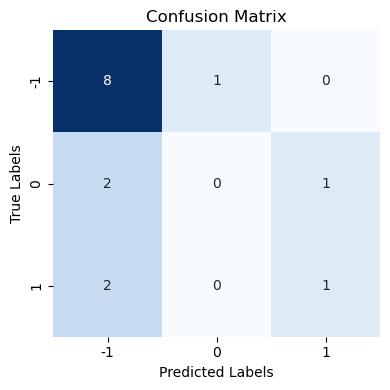

Performance Metrics:
--------------------
Accuracy: 0.6000
Macro-Precision: 0.3889
Macro-Recall: 0.4074
Macro-F1 Score: nan
Micro-Precision: 0.6000
Micro-Recall: 0.6000
Micro-F1 Score: 0.6000


In [4]:

# Define class labels (replace with your actual class labels)
class_labels = ['-1', '0', '1',]


# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(confusion, annot=True, fmt="d", cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Customize plot appearance
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Display the plot
plt.show()

# Calculate overall accuracy
total_samples = confusion.sum()
correct_predictions = confusion.diagonal().sum()
accuracy = correct_predictions / total_samples

# Calculate precision, recall, and F1-score for each class
precision = confusion.diagonal() / confusion.sum(axis=0)
recall = confusion.diagonal() / confusion.sum(axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Calculate macro-averaged metrics
macro_precision = precision.mean()
macro_recall = recall.mean()
macro_f1_score = f1_score.mean()

# Calculate micro-averaged metrics
micro_precision = correct_predictions / total_samples
micro_recall = correct_predictions / total_samples
micro_f1_score = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)

# Print performance metrics
print("Performance Metrics:")
print("--------------------")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro-Precision: {macro_precision:.4f}")
print(f"Macro-Recall: {macro_recall:.4f}")
print(f"Macro-F1 Score: {macro_f1_score:.4f}")
print(f"Micro-Precision: {micro_precision:.4f}")
print(f"Micro-Recall: {micro_recall:.4f}")
print(f"Micro-F1 Score: {micro_f1_score:.4f}")

In [6]:
import os
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torchvision.models as models
from torchvision.transforms import transforms

class CustomDataset(Dataset):
    def __init__(self, image_dir, labeled_images, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.filenames = [file for file in os.listdir(image_dir) if file.endswith('.png') and file not in labeled_images]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        file_name = self.filenames[idx]
        img_path = os.path.join(self.image_dir, file_name)

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, file_name

# Set random seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the directory paths
image_dir = '/kaggle/working/padded_images'
image_dir = '/kaggle/input/oxml-carinoma-classification'

# Load labeled images from labels.csv
labeled_images = labeled_data['id'].astype(str).values
labeled_images ='img_' + labeled_images + '.png'
# Define the main data transform
main_transform = transforms.Compose([
    transforms.Resize((max_height, max_width)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create the main dataset
dataset = CustomDataset(image_dir, labeled_images, transform=main_transform)

# Create the data loader
batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Load the trained model weights
resnet_model.load_state_dict(torch.load('best_resnet_model_acc.pth'))
efficientnet_model.load_state_dict(torch.load('best_efficientnet_model_acc.pth'))
inception_model.load_state_dict(torch.load('best_inception_model_acc.pth'))
googlenet_model.load_state_dict(torch.load('best_googlenet_model_acc.pth'))

# Testing phase
resnet_model.eval()
efficientnet_model.eval()
inception_model.eval()
googlenet_model.eval()

predictions = []

with torch.no_grad():
    for images, filenames in dataloader:
        images = images.to(device)

        # ResNet50
        resnet_outputs = resnet_model(images)

        # EfficientNetV2
        efficientnet_outputs = efficientnet_model(images)

        # Inception V3
        inception_outputs = inception_model(images)

        # GoogLeNet
        googlenet_outputs = googlenet_model(images)

        # Combine predictions
        combined_outputs = (resnet_outputs + efficientnet_outputs + inception_outputs + googlenet_outputs) / 4.0

        predicted_labels = torch.argmax(combined_outputs, dim=1)
        predicted_labels = predicted_labels.cpu().detach().numpy() - 1

        for filename, label in zip(filenames, predicted_labels):
            predictions.append([filename, label])

# Create a DataFrame for the predictions
output = pd.DataFrame(predictions, columns=['id', 'malignant'])
# Convert the 'id' column to integer type
output['id'] = output['id'].str.replace('.png', '', regex=False).str.replace('img_', '', regex=False).astype(int)

# Sort the output DataFrame by "id"
output.sort_values(by="id", inplace=True)

# Save the predictions to a CSV file
output.to_csv('/kaggle/working/submission.csv', index=False)

print("Predictions saved successfully!")


Predictions saved successfully!


In [7]:
pd.read_csv('submission.csv')


,id,malignant
0,5042,-1
1,28148,-1
2,35946,1
3,37944,0
4,39157,-1
...,...,...
119,959476,-1
120,968389,-1
121,976505,1
122,996288,-1
